In [39]:
import networkx as nx
from collections import defaultdict
import json
from collections import Counter
from operator import neg
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

In [44]:
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/agh4m/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/agh4m/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/agh4m/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/agh4m/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/agh4m/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [45]:
# Step 2: Load the dataset
file_path = "results-publico-translated.csv"
columns = ["term", "url", "text", "title", "translated_text"]
df = pd.read_csv(file_path, header=1, names=columns)

In [46]:
# Check for missing values; address any missing data if necessary
has_missing = df.isnull().values.any()
if has_missing:
    print('Missing values found. Dropping rows with missing values.')
    df.dropna(inplace=True)
else:
    print('No missing values found.')
df['text'] = df['text'].str.strip().str.lower()
df.drop_duplicates(subset='text', keep='first', inplace=True)
print(len(df))

Missing values found. Dropping rows with missing values.
8489


In [48]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

stop_words.add('goes')
stop_words.add('newspaper')
stop_words.add('journalist')
stop_words.add('journalists')
stop_words.add('pt')
stop_words.add('rsf')
stop_words.add('aacs')
stop_words.add('still')
stop_words.add('year')
stop_words.add('today')
stop_words.add('day')
stop_words.add('to have')
stop_words.add('about')
stop_words.add('hurts')
stop_words.add('yesterday')
stop_words.add('where')
stop_words.add('one')
stop_words.add('two')
stop_words.add('three')
stop_words.add('four')
stop_words.add('five')
stop_words.add('six')
stop_words.add('seven')
stop_words.add('eight')
stop_words.add('nine')
stop_words.add('ten')
stop_words.add('because')
stop_words.add('years')
stop_words.add('said')

# Tokenize the text


def tokenize(text):
    tokens = word_tokenize(text, language='english')
    for token in tokens:
        lword = token.lower()
        if lword.isalpha() and (lword not in stop_words) and (len(lword) > 2):
            lemWord = lemmatizer.lemmatize(lword)
            yield lemWord


# Step 3: Tokenize the text
df['tokens'] = df['translated_text'].apply(lambda x: [t for t in tokenize(x)])
# join the tokens back into a single string
df['cleaned_text'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

term                                                url  \
0  ABEL BAPTISTA  https://arquivo.pt/noFrame/replay/200802290423...   
1  ABEL BAPTISTA  https://arquivo.pt/noFrame/replay/200802290428...   
2  ABEL BAPTISTA  https://arquivo.pt/noFrame/replay/200503240713...   
3  ABEL BAPTISTA  https://arquivo.pt/noFrame/replay/200802290434...   
4  ABEL BAPTISTA  https://arquivo.pt/noFrame/replay/200503241002...   

                                                text       title  \
0  a proposta, que será apresentada na assembleia...  PÚBLICO.PT   
1  na comissão executiva desde o início do ano, h...  PÚBLICO.PT   
2  público - edição impressa - destaque  director...  PUBLICO.PT   
3  miguel angel garçon, da telefónica, disse à lu...  PÚBLICO.PT   
4  público - edição impressa - destaque  director...  PUBLICO.PT   

                                     translated_text  \
0  The proposal, which will be presented at the g...   
1  On the executive committee since the beginning...   
2  Público - printed edition - featured director:...   
3  Miguel Angel Garçon, from Telefónica, told Lus...   
4  public - print edition - highlights director: ...   

                                              tokens  \
0  [proposal, presented, general, shareholder, me...   
1  [executive, committee, since, beginning, henri...   
2  [público, printed, edition, featured, director...   
3  [miguel, angel, garçon, telefónica, told, lusa...   
4  [public, print, edition, highlight, director, ...   

                                        cleaned_text  
0  proposal presented general shareholder meeting...  
1  executive committee since beginning henrique g...  
2  público printed edition featured director josé...  
3  miguel angel garçon telefónica told lusa compa...  
4  public print edition highlight director josé m...

In [50]:
# Step 3: Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Step 4: Analyze Sentiment


def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']


df['compound_score'] = df['cleaned_text'].apply(analyze_sentiment)

# Step 5: Map Compound Scores to Sentiment Labels


def map_sentiment(compound):
    return "positive" if compound > 0 else "negative"


df['sentiment'] = df['compound_score'].apply(map_sentiment)

# Step 6: Save results or preview
print(df[['text', 'compound_score', 'sentiment']].head())

                                                text  compound_score sentiment
0  a proposta, que será apresentada na assembleia...          0.7096  positive
1  na comissão executiva desde o início do ano, h...          0.9883  positive
2  público - edição impressa - destaque  director...          0.9413  positive
3  miguel angel garçon, da telefónica, disse à lu...          0.9423  positive
4  público - edição impressa - destaque  director...         -0.8827  negative


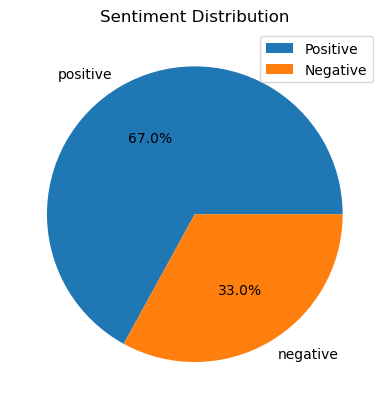

In [51]:
# plot the sentiment distribution
fig = df['sentiment'].value_counts().plot(kind="pie", autopct='%1.1f%%')
fig.set_title('Sentiment Distribution')
fig.set_ylabel('')
fig.set_xlabel('')
fig.legend(labels=['Positive', 'Negative'])
plt.show()

In [52]:
# Get the most common Names of People in negative and positive texts

with open("./Legislaturas/X.json") as json_file:
    legislature_json = json.load(json_file)

legislature = legislature_json["Legislatura"]

l_init_date = legislature["DetalheLegislatura"]["dtini"]  # 2005-03-10
l_end_date = legislature["DetalheLegislatura"]["dtfim"]  # 2009-10-14

deputies = legislature["Deputados"]["pt_ar_wsgode_objectos_DadosDeputadoSearch"]
parties = legislature["GruposParlamentares"]["pt_gov_ar_objectos_GPOut"]

deputies = [{
    "depId": dep["depId"],
    "depNomeParlamentar": dep["depNomeParlamentar"],
    "depNomeCompleto": dep["depNomeCompleto"],
    "gpId": dep["depGP"]["pt_ar_wsgode_objectos_DadosSituacaoGP"]["gpId"] if type(dep["depGP"]["pt_ar_wsgode_objectos_DadosSituacaoGP"]) is not list else dep["depGP"]["pt_ar_wsgode_objectos_DadosSituacaoGP"][-1]["gpId"],
    "gpSigla": dep["depGP"]["pt_ar_wsgode_objectos_DadosSituacaoGP"]["gpSigla"] if type(dep["depGP"]["pt_ar_wsgode_objectos_DadosSituacaoGP"]) is not list else dep["depGP"]["pt_ar_wsgode_objectos_DadosSituacaoGP"][-1]["gpSigla"]
}
    for dep in deputies
]

dp_df = pd.DataFrame(
    deputies,
    columns=["depId", "depNomeParlamentar", "depNomeCompleto", "gpId", "gpSigla"],
)
party_df = pd.DataFrame(parties)

dp_df

depId     depNomeParlamentar  \
0    2249          ABEL BAPTISTA   
1    2139  ABÍLIO DIAS FERNANDES   
2    2269             ADÃO SILVA   
3    2091          AFONSO CANDAL   
4    2495   AGOSTINHO BRANQUINHO   
..    ...                    ...   
347  2180         VÍTOR BAPTISTA   
348  2147     VÍTOR HUGO SALGADO   
349  2170          VÍTOR PEREIRA   
350  2340          VITOR RAMALHO   
351  2286            ZITA SEABRA   

                                  depNomeCompleto gpId gpSigla  
0                              ABEL LIMA BAPTISTA  239  CDS-PP  
1            ABÍLIO MIGUEL JOAQUIM DIAS FERNANDES  238     PCP  
2                         ADÃO JOSÉ FONSECA SILVA  237     PSD  
3         LUÍS AFONSO CERQUEIRA NATIVIDADE CANDAL  236      PS  
4                    AGOSTINHO CORREIA BRANQUINHO  237     PSD  
..                                            ...  ...     ...  
347                   VÍTOR MANUEL BENTO BAPTISTA  236      PS  
348  VÍTOR HUGO MACHADO DA COSTA SALGADO DE ABREU  236      PS  
349                 VÍTOR MANUEL PINHEIRO PEREIRA  236      PS  
350          VITOR MANUEL SAMPAIO CAETANO RAMALHO  236      PS  
351                  ZITA MARIA DE SEABRA ROSEIRO  237     PSD  

[352 rows x 5 columns]

In [53]:
with open("./Legislaturas/GOV.json") as json_file:
    gov_json = json.load(json_file)

gov = gov_json["membros"]

gov_df = pd.DataFrame(
    gov,
    columns=["nome", "cargos"],
)

gov_df

nome  \
0                José Sócrates   
1                   Luís Amado   
2          Pedro Silva Pereira   
3                  Rui Pereira   
4      Francisco Nunes Correia   
5                   Mário Lino   
6                    Ana Jorge   
7                 Mariano Gago   
8         Augusto Santos Silva   
9          Teixeira dos Santos   
10     Nuno Severiano Teixeira   
11               Alberto Costa   
12                 Jaime Silva   
13        José Vieira da Silva   
14   Maria de Lurdes Rodrigues   
15  José António Pinto Ribeiro   

                                               cargos  
0                                 [Primeiro-Ministro]  
1   [Ministro de Estado, Ministro dos Negócios Est...  
2                           [Ministro da Presidência]  
3                 [Ministro da Administração Interna]  
4   [Ministro do Ambiente, do Ordenamento do Terri...  
5   [Ministro das Obras Públicas, Transportes e Co...  
6                                 [Ministra da Saúde]  
7   [Ministro da Ciência, Tecnologia e Ensino Supe...  
8               [Ministro dos Assuntos Parlamentares]  
9   [Ministro de Estado, Ministro das Finanças, Mi...  
10                      [Ministro da Defesa Nacional]  
11                              [Ministro da Justiça]  
12  [Ministro da Agricultura, do Desenvolvimento R...  
13   [Ministro do Trabalho e da Solidariedade Social]  
14                             [Ministra da Educação]  
15                              [Ministro da Cultura]

In [54]:
# Get one member of the government by the cargo


def get_member_by_cargo(cargo):
    for member in gov:
        if cargo.lower() in list(map(lambda x: x.lower(), member['cargos'])):
            return member['nome']
    return None

In [63]:
def get_people_names(text):
    people_names = []
    all_names = []
    # Do not tokenize
    deputies_names = dp_df['depNomeParlamentar'].values
    gov_names = gov_df['nome'].values

    # merge the two lists of names
    all_names.extend(deputies_names)
    all_names.extend(gov_names)

    # Use lower case to remove duplicates
    all_names = list(set(
        [name.lower() for name in all_names]
    ))
    for name in all_names:
        if name.lower() in text:
            people_names.append(name)

    # Check for the existence of positions referring to people
    cargos = gov_df['cargos'].values
    cargos = [cargo for sublist in cargos for cargo in sublist]

    for cargo in cargos:
        if cargo.lower() in text or cargo.replace('-', ' ').lower() in text:
            member = get_member_by_cargo(cargo)
            if member is not None:
                people_names.append(member)

    return people_names


df['people_names'] = df['text'].apply(get_people_names)
print(df[['text', 'people_names']].head())

                                                text  \
0  a proposta, que será apresentada na assembleia...   
1  na comissão executiva desde o início do ano, h...   
2  público - edição impressa - destaque  director...   
3  miguel angel garçon, da telefónica, disse à lu...   
4  público - edição impressa - destaque  director...   

                                        people_names  
0                                                 []  
1                                    [José Sócrates]  
2  [manuel maria carrilho, vítor baptista, maria ...  
3                                                 []  
4  [manuel maria carrilho, vítor baptista, maria ...  


In [64]:
# Get the most common names of people in positive and negative texts
positive_people_names = [name for names in df[df['sentiment']
                                              == 'positive']['people_names'] for name in names]
negative_people_names = [name for names in df[df['sentiment']
                                              == 'negative']['people_names'] for name in names]

positive_people_names_counter = Counter(positive_people_names)
negative_people_names_counter = Counter(negative_people_names)

print('Most common names of people in positive texts:',
      positive_people_names_counter.most_common(5))
print('Most common names of people in negative texts:',
      negative_people_names_counter.most_common(5))

Most common names of people in positive texts: [('José Sócrates', 690), ('josé sócrates', 462), ('manuel alegre', 191), ('paulo portas', 170), ('Luís Amado', 165)]
Most common names of people in negative texts: [('José Sócrates', 296), ('josé sócrates', 158), ('francisco louçã', 68), ('Teixeira dos Santos', 68), ('Luís Amado', 57)]


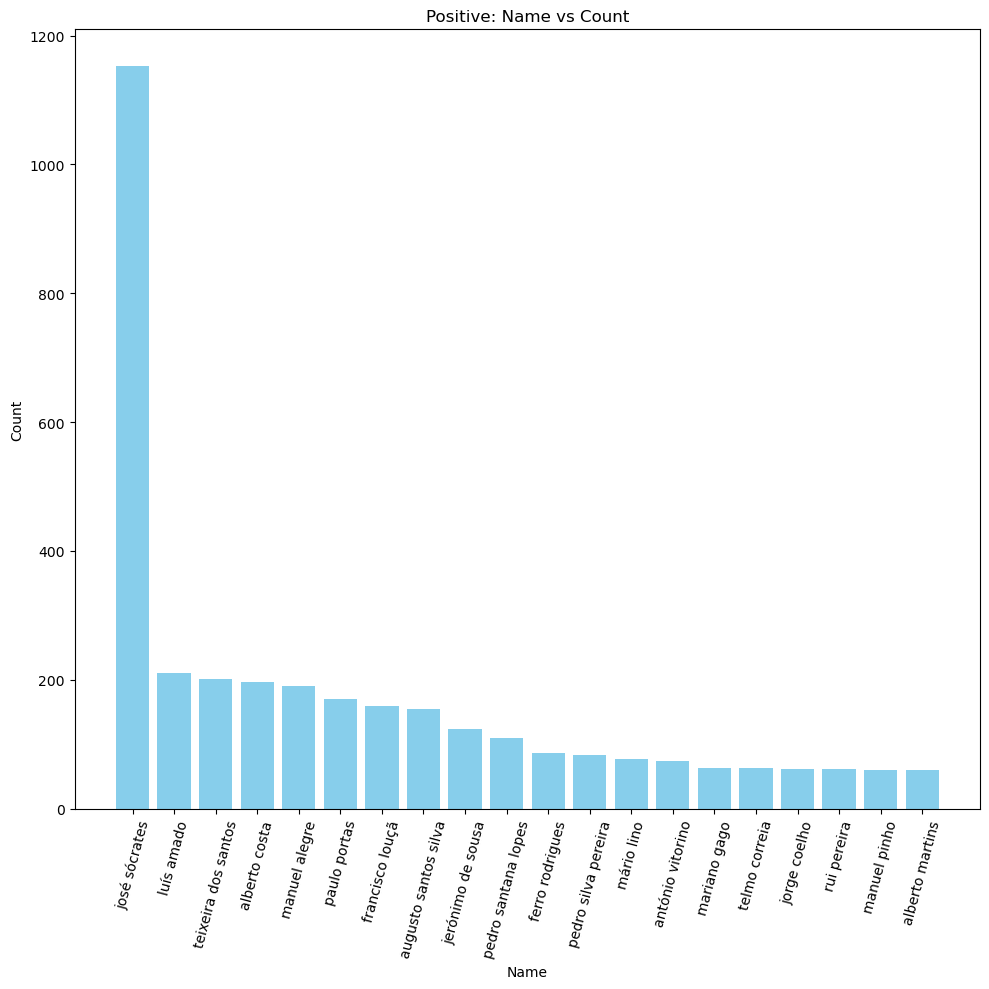

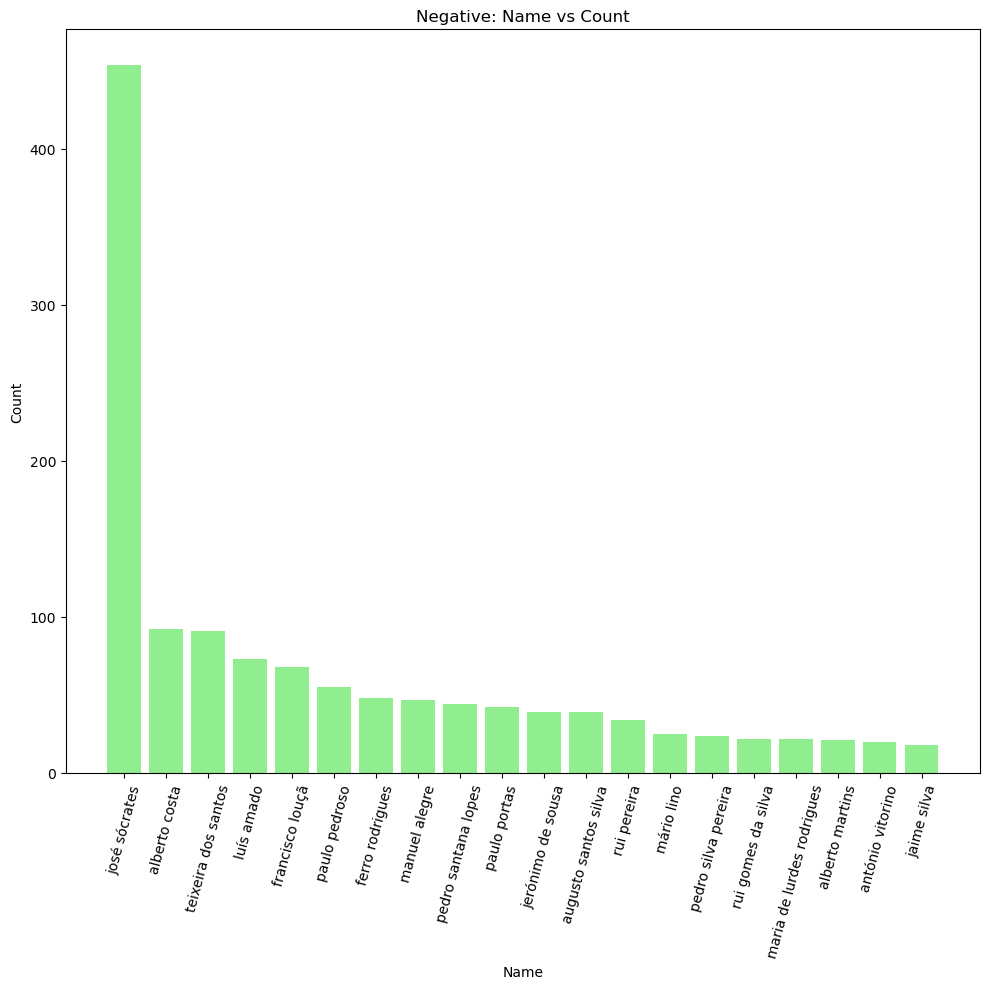

In [65]:
def process_data(input_data):
    combined_counts = Counter()
    for name, count in input_data.items():
        normalized_name = name.lower()
        combined_counts[normalized_name] += count
    sorted_counts = sorted(combined_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_counts[:20]


# Convert combined_counts to lists for plotting
# Sort combined_counts by count in descending order
sorted_counts = process_data(positive_people_names_counter)
neg_sorted_counts = process_data(negative_people_names_counter)

# Convert sorted_counts to lists for plotting
names, counts = zip(*sorted_counts)
neg_names, neg_counts = zip(*neg_sorted_counts)

# Plotting the first dataset
plt.figure(figsize=(10, 10))
plt.bar(names, counts, color="skyblue")
plt.xlabel("Name")
plt.ylabel("Count")
plt.title("Positive: Name vs Count")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

# Plotting the second dataset
plt.figure(figsize=(10, 10))
plt.bar(neg_names, neg_counts, color="lightgreen")
plt.xlabel("Name")
plt.ylabel("Count")
plt.title("Negative: Name vs Count")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

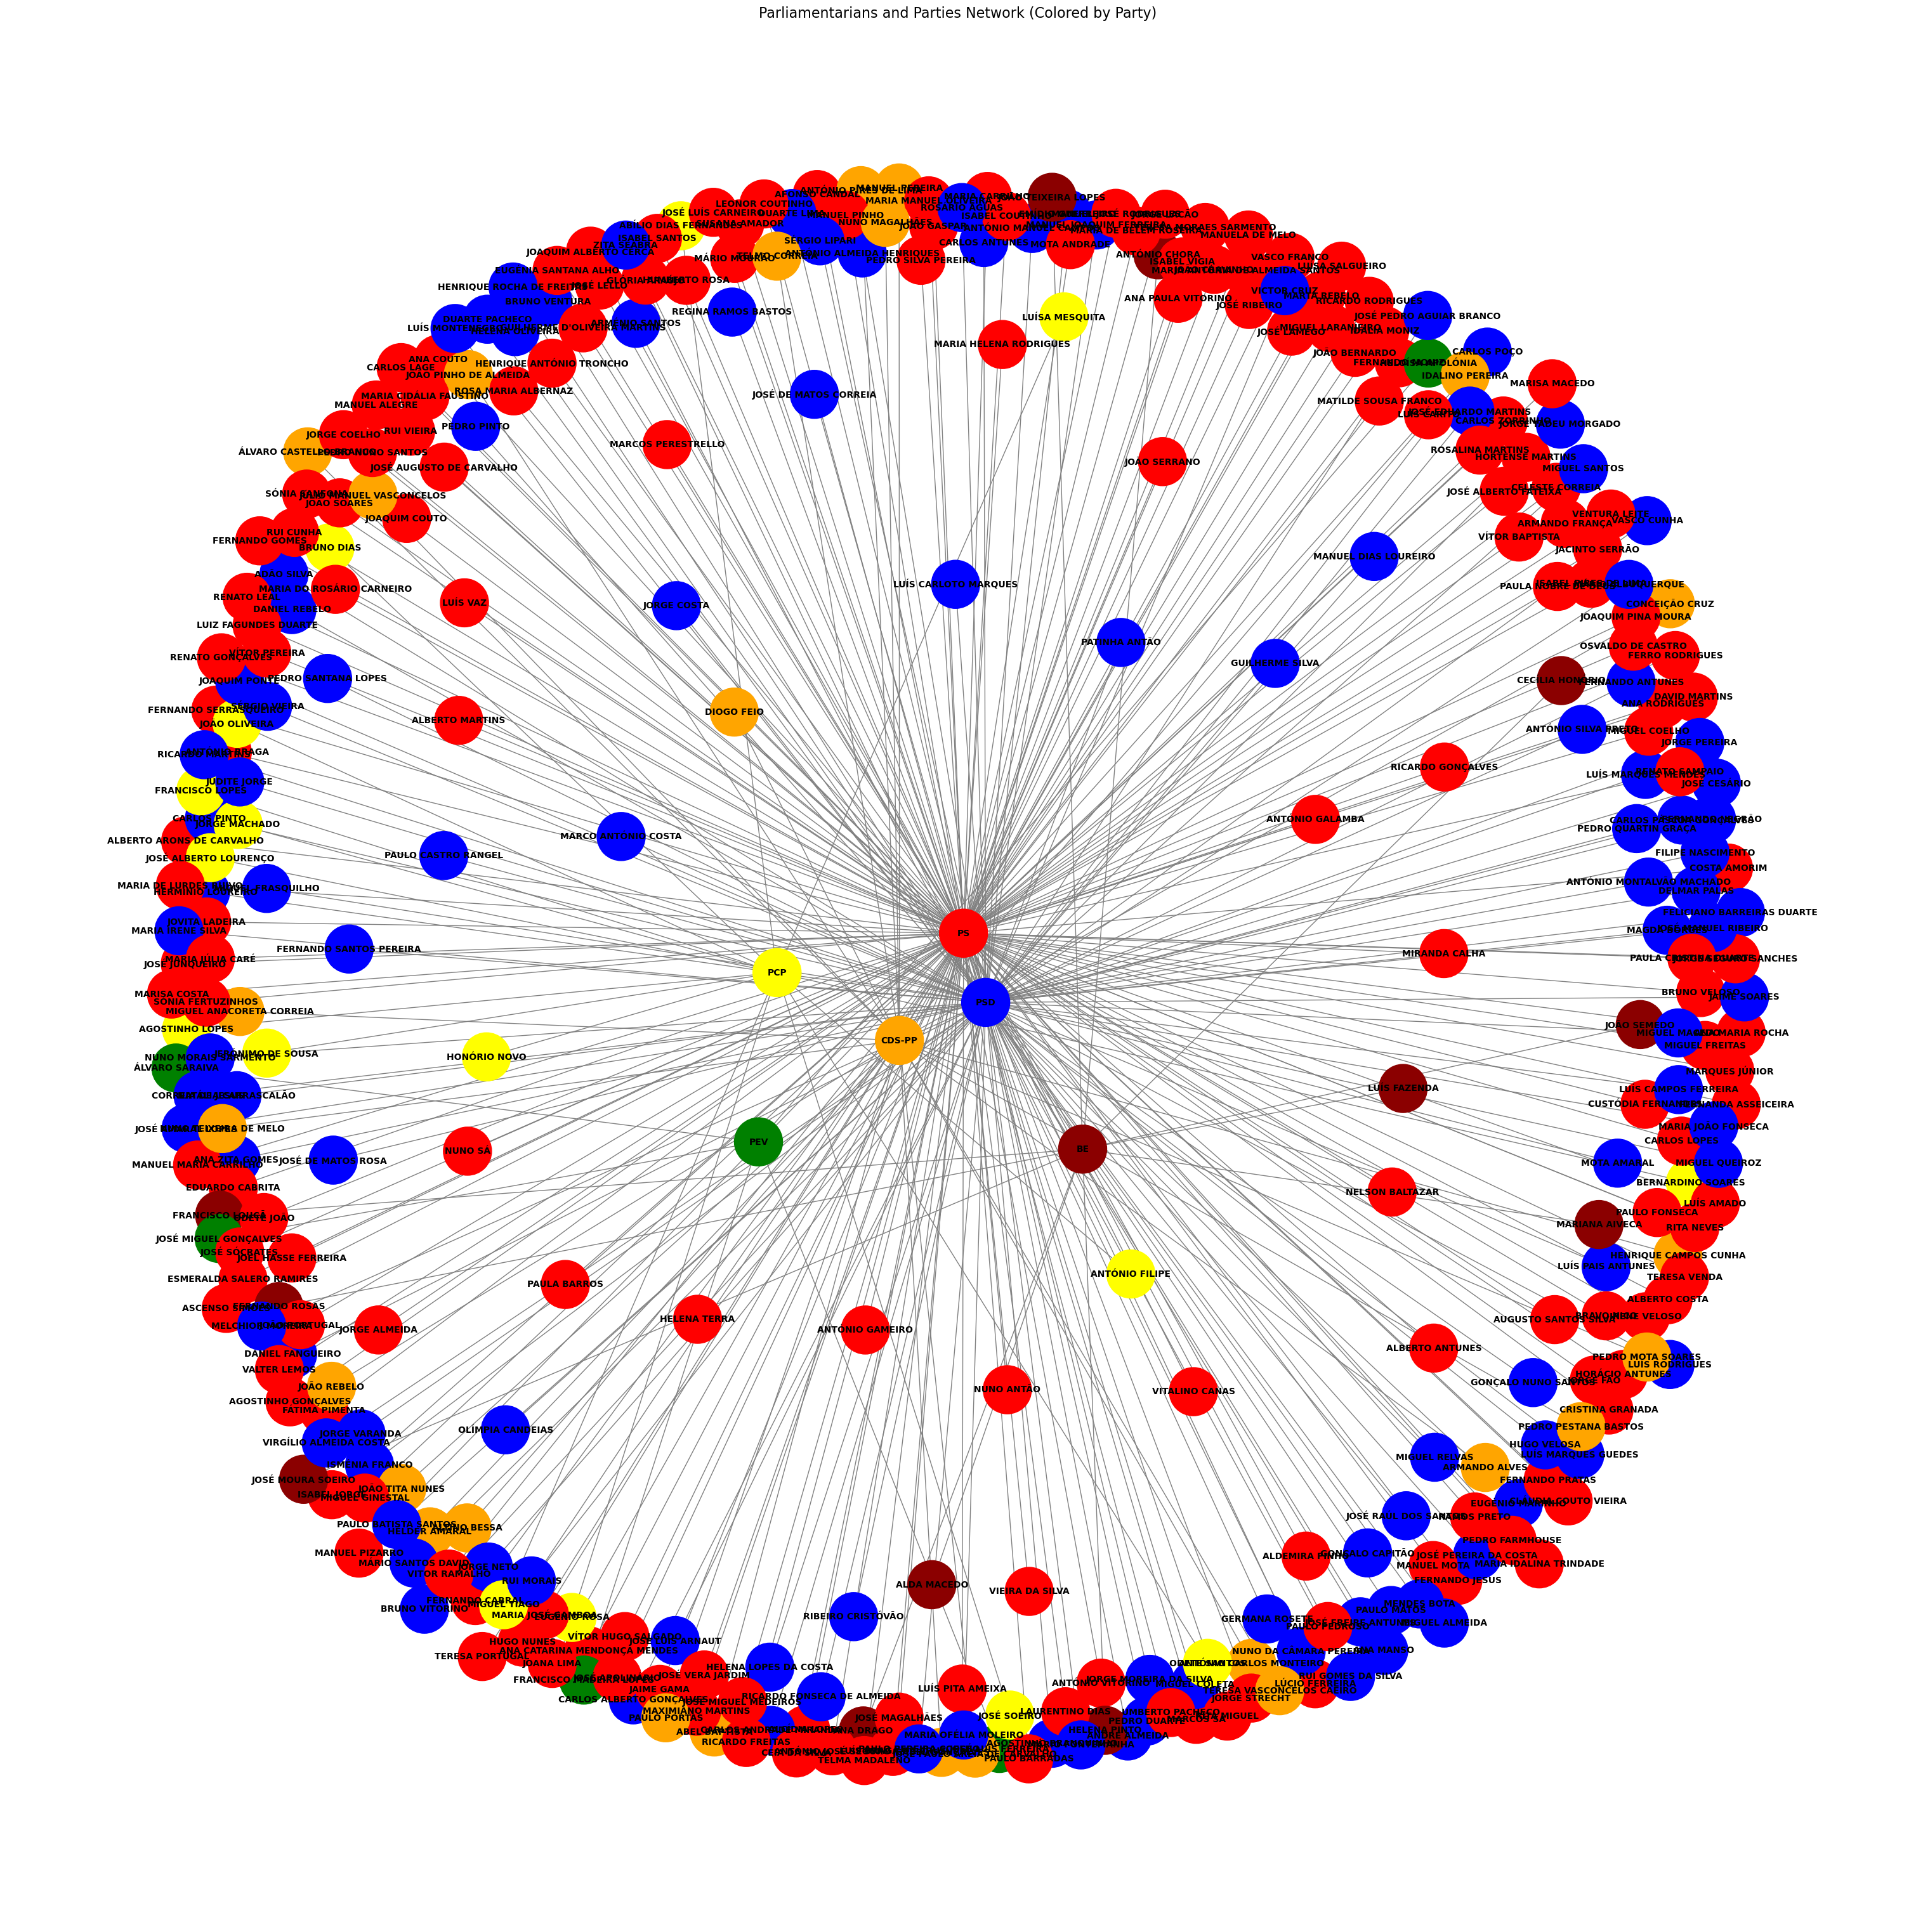

In [77]:
# Create a graph
G = nx.Graph()

# Add edges from depNomeParlamentar to gpSigla (party)
for _, row in dp_df.iterrows():
    G.add_edge(row['depNomeParlamentar'], row['gpSigla'])

# Assign unique colors to parties
party_colors = {
    'PEV': 'green',
    'PSD': 'blue',
    'PS': 'red',
    'BE': 'darkred',
    'PCP': 'yellow',
    'CDS-PP': 'orange'
}

# Assign colors to nodes
node_colors = []
for node in G.nodes():
    if node in dp_df['gpSigla'].values:  # Party nodes
        node_colors.append(party_colors.get(node, 'gray'))
    else:  # Parliamentarian nodes
        # Color parliamentarians based on the party they are connected to
        party = dp_df[dp_df['depNomeParlamentar'] == node]['gpSigla'].values[0]
        node_colors.append(party_colors.get(party, 'gray'))

# Draw the graph
plt.figure(figsize=(30, 30))
pos = nx.spring_layout(G, k=0.7, scale=3)  # Spread nodes out

nx.draw(
    G, pos, with_labels=True,
    node_color=node_colors,  # Apply colors
    node_size=3000,
    font_size=10,
    font_weight="bold",
    edge_color="gray"
)

plt.title("Parliamentarians and Parties Network (Colored by Party)", fontsize=16)
plt.show()

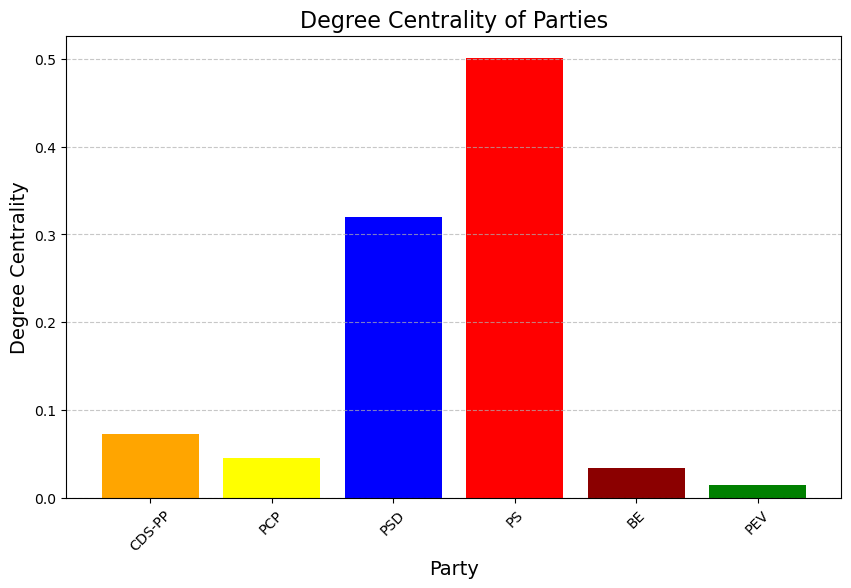

In [80]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Extract degree centrality for party nodes
party_degree_centrality = {node: degree_centrality[node] for node in dp_df['gpSigla'].unique()}

# Plot degree centrality
plt.figure(figsize=(10, 6))
plt.bar(
    party_degree_centrality.keys(),
    party_degree_centrality.values(),
    color=['orange', 'yellow', 'blue', 'red', 'darkred', 'green']
)
plt.title("Degree Centrality of Parties", fontsize=16)
plt.xlabel("Party", fontsize=14)
plt.ylabel("Degree Centrality", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
def process_data_2(input_data):
    combined_counts = Counter()
    for name, count in input_data.items():
        normalized_name = name.lower()
        combined_counts[normalized_name] += count
    sorted_counts = sorted(combined_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_counts


normalized_positive_counts = process_data(positive_people_names_counter)
normalized_negative_counts = process_data(negative_people_names_counter)

name_to_party = {row['depNomeParlamentar'].lower(): row['gpSigla']
                 for index, row in dp_df.iterrows()}